Loading Libraries
Loading Spacy Model en_core_web_md.  This could take a while...
Complete
Loading 454 stop words from ['## Common ##', '## Media ##']
Pulling Blue articles from last 24 hours.
Completed pulling 24 articles.
    Latest article is from 2018-04-20 19:05:47 UTC
Adding 454 custom stop words to Spacy Model en_core_web_md.
Complete. There are 639 stop words in the list.
Filtering stops and words shorter than 3 letters. 
Chunking and identifying ['PERSON', 'GPE', 'ORG', 'NORP'] entities from cleaned corpus.
Done inserting 8015 chunks and entities into df.chunks_ents.)
Loading Vectorizer Paramaters
Fitting Vectorizor on chunks_ents column
topic 0 : Dugin   Spencer   Heimbach   Putin   LaRouche   Moscow   Duke   Russia   David Duke   the Russian Imperial Movement
topic 1 : Forbes   Donald   Fred   Cohn   O'Brien   Fred Trump   Jonathan Greenberg   Roy Cohn   Barron   Atlantic City
topic 2 : Cohen   Getty Images   the Secret Service   Jabin Botsford   Photo   Brendan Smialowski  

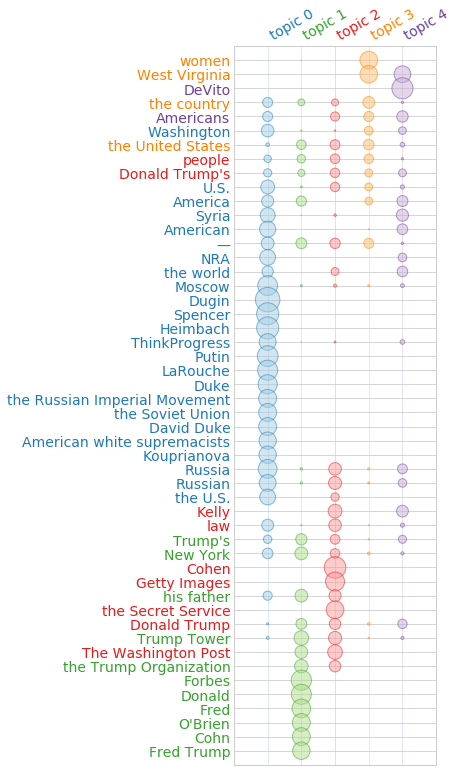

In [49]:
## Library Imports
print("Loading Libraries")

# Standard Libraries 
import pandas as pd
import numpy as np
import re, string
import os

from datetime import datetime, timedelta, timezone
import pytz

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

# MongoDB
from pymongo import MongoClient

# NLP Libraries
import textacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Timezone Info - Fix Docker container for matching timezone
local_tz = pytz.timezone('America/Los_Angeles')

os.environ['TZ'] = 'America/Los_Angeles'

print(f"Loading Spacy Model {spacy_model}.  This could take a while...")

nlp = spacy.load(spacy_model)

print("Complete")

def utc_to_local(utc_dt):
    local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(local_tz)
    return local_tz.normalize(local_dt)

utc_to_local(datetime.now())

## Import Parameters from Topic_Extractor_Params.dat

def param_loader(file):
    '''A loader definition for loading script dependant parameters'''
    
    fileObj = open(file, mode='r')

    params = {}

    for line in fileObj:
        line = line.strip()
        
        key_value = line.split('=')
        
        if len(key_value) == 2:
            params[key_value[0].strip()] = key_value[1].strip()
            
    return params

def stop_loader(file, as_list=True):
    '''A loader for loading a unicode file of stop words as dictionaries.
    Keys are categories and Values are lists of terms'''
    
    fileObj = open(file, mode='r')
    
    vocab_dict = {}
    vocab_list = []
    current_key = ""
    
    for line in fileObj.read().split('\n'):
        
        if not line:
            continue
            
        if not line[0].isalpha():
            vocab_list = []
            vocab_dict[line] = []
            current_key = str(line)
        
        if line[0].isalpha():
            vocab_list.append(line)
        
        vocab_dict[current_key] = vocab_list
        
    if as_list:
        vocab_list = []
        for terms in vocab_dict.values():
            vocab_list.extend(terms)
        print(f"Loading {len(vocab_list)} stop words from {list(vocab_dict.keys())}")
        return vocab_list
    
    return vocab_dict

def stop_fixer(file, upper=True, no_punct=True, fix_in_place=False):
    
    '''Reads and parses *file* - Returns list of stops or (if fix_in_place) overwrites existing *file*
    (if upper) adds capitlized version of stop words
    (if no_punct) adds unpunctuated version of stop words'''
    
    vocab_dict = stop_loader('Stop_Words_List.dat', as_list = False)
    
    for key in vocab_dict:
        if no_punct or upper:
            for word in vocab_dict[key]:
                if no_punct:
                    word_punct = re.sub('[^A-Za-z0-9]+', '', word)
                    if word_punct not in vocab_dict[key]:
                        vocab_dict[key].append(word_punct)
                
                if upper:
                    word_caps = word.capitalize()
                    if word_caps not in vocab_dict[key]:
                        vocab_dict[key].append(word_caps)
    
       
        sorted(vocab_dict[key], key=str.lower)
        vocab_dict[key] = sorted(vocab_dict[key], key=str.lower)
        
    if fix_in_place:
        
        writer = open(file, mode='w+')
        
        for key in vocab_dict:
            writer.writelines('\n' + key + '\n')
            for word in vocab_dict[key]:
                writer.writelines(word  + '\n')
    else:        
        return vocab_dict

def spacy_stopword_adder():
    print(f"Adding {len(stop_words_list)} custom stop words to Spacy Model {spacy_model}.")
    
    for stopword in stop_words_list:
        STOP_WORDS.add(stopword)
        
    nlp.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)
    print(f"Complete. There are {len(STOP_WORDS)} stop words in the list.")
    

def mongo_query():
    
    client = MongoClient(host=mongo_host, port=mongo_port)
    
    db = client.Politiprocess
    
    collection = db.reddit_posts
    
    query = {'is article': True}
    
    if n_hours == 0:
        print(f"Pulling all articles from {red_or_blue} targets.")
    else:
        print(f"Pulling {red_or_blue} articles from last {n_hours} hours.")
        dt = datetime.utcnow() - timedelta(hours=n_hours)
        query['date'] = {'$gt': dt}
    
    if red_or_blue == 'Red':
        query['target'] = True
        
    elif red_or_blue == 'Blue':
        query['target'] = False
        
    else:
        pass
    
    df = pd.DataFrame(list(collection.find(query)))
    
    print(f'''Completed pulling {len(df)} articles.
    Latest article is from {collection.find_one(sort=[('date', -1)])['date']} UTC''')
    
    return df

def pre_processor():
    cleaned = [] 
    for x in range(len(df)):
        text = textacy.preprocess.preprocess_text(df.text[x],
                                            fix_unicode=fix_unicode,
                                            lowercase=lowercase,
                                            no_punct=no_punctuation,
                                            no_contractions=no_contradictions,
                                            no_currency_symbols=no_currency,
                                            no_emails=no_emails,
                                            no_accents=no_accents)
        if no_newline:
            text = text.replace('\n', ' ') 
        
        cleaned.append(text)
    
    return cleaned

def spacy_processing(use_cleaned, split_columns):  
    
    if use_cleaned:
        corpus    = 'cleaned'
        df_column = 'cleaned'
    else:
        corpus    = 'raw'
        df_column = 'text'   
    
    print(f'''Filtering stops and words shorter than {min_word_length + 1} letters. 
Chunking and identifying {named_entities} entities from {corpus} corpus.''')    
    
    chunks_list = []
    ents_list   = []
    
    for text in df[df_column]:
        
        doc = nlp(str(text))
        
        chunks = []
        ents   = []
        
        for span in doc.noun_chunks:
            if len(span) == 1:
                if span[0].is_stop or len(span[0]) <= min_word_length:
                    continue
                else:
                    chunks.append(span.text)
                    continue
            else:
                chunks.append(span.text)
        
        for ent in doc.ents:
            if ent.label_ in named_entities:
                ents.append(ent.text)
                
        chunks_list.append(chunks)
        ents_list.append(ents)
    
    if split_columns:
        df['chunks'], df['ents'] = chunks_list, ents_list
        del chunks_list, ents_list
        print(f'''Done inserting {len(df.chunks.sum())} chunks and
              {len(df.ents.sum())} entities into df.chunks and df.ents.''')
    else:
        joined_list = [a + b for a, b in zip(chunks_list, ents_list)]
        del chunks_list, ents_list
        df['chunks_ents'] = joined_list
        del joined_list
        print(f"Done inserting {len(df.chunks_ents.sum())} chunks and entities into df.chunks_ents.)")

def topic_modeler(save=True, visualize=True, *args):    
    
    print(f"Loading Vectorizer Paramaters")
    
    vocabulary=None
    
    vectorizer = textacy.vsm.Vectorizer(weighting, normalize, sublinear_tf,
                                        smooth_idf, vocabulary, min_df, max_df,
                                        min_ic, max_n_terms)
    
    print(f"Fitting Vectorizor on {column} column")
    
    doc_term_matrix = vectorizer.fit_transform(df[column])
    
    model = textacy.tm.TopicModel(model_type, n_topics=n_topics)
    model.fit(doc_term_matrix)
    
    topics_string = ""
    
    for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=top_n_terms):
        topics_string += ' - '.join(top_terms) + ' '
        print('topic', topic_idx, ':', '   '.join(top_terms))
        
    if visualize:
        if isinstance(save, str):
            save = save
        elif save is True:
            time_stamp = str(utc_to_local(datetime.now()).strftime('%m_%d_%y_%H_%M'))
            save = f"{directory}/{n_hours}hr_{}_{red_or_blue}_{column}_{time_stamp}"
        
        model.termite_plot(doc_term_matrix, vectorizer.id_to_term, highlight_topics=highlight,
                       topics=-1,  n_terms=term_depth, sort_terms_by=sort_terms_by, save=save)
        


## Assign Params from .dats ##

topic_params =    param_loader('Topic_Extractor_Params.dat')
mongo_params =    param_loader('../Scraper_Params.dat')

## Stop Words ##
stop_words_list = stop_loader('Stop_Words_List.dat')

## Mongo Params ##

mongo_host        = str(mongo_params['mongodb_host'])
mongo_port        = int(mongo_params['mongodb_port'])

## Query Params ##

n_hours           = int(topic_params['Time Frame in Hours'])
red_or_blue       = str(topic_params['Red, Blue or All'])

## Cleaner Params ##

fix_unicode       = bool(int(topic_params['Fix Unicode']))
lowercase         = bool(int(topic_params['All Lowercase']))
no_accents        = bool(int(topic_params['Remove Accents']))
no_contradictions = bool(int(topic_params['Remove Contradictions']))
no_emails         = bool(int(topic_params['Remove Emails']))
no_newline        = bool(int(topic_params['Remove Newline']))
no_punctuation    = bool(int(topic_params['Remove Punctuation']))
no_currency       = bool(int(topic_params['Replace Currency']))

## Spacy Params ##

spacy_model       = str(topic_params['Spacy Model'])
min_word_length   = int(topic_params['Min Word Length'])
use_cleaned       = bool(int(topic_params['Use Cleaned Text']))
split_columns     = bool(int(topic_params['Split Columns']))
named_entities    = topic_params['Named Entity List'].split(' ')

## TFIDF Params ## 

if bool(int(topic_params['Use IDF'])):
    weighting     = 'tfidf'
else:
    weighting     = 'tf'
    
if topic_params['Max Terms'] == '0':
    max_n_terms   = None
else:
    max_n_terms   = int(topic_params['Max Terms'])
    
column            = str(topic_params['Column to Vectorize'])
normalize         = bool(int(topic_params['Normalize']))
sublinear_tf      = bool(int(topic_params['Sublinear TF']))
smooth_idf        = bool(int(topic_params['Smooth IDF']))
vocabulary        = topic_params['Vocabulary']
min_df            = float(topic_params['Min DF'])
max_df            = float(topic_params['Max DF'])
min_ic            = float(topic_params['Min IC'])

## Decomposition Params ##
n_topics          = int(topic_params['Number of Topics'])
model_type        = str(topic_params['Model Type'])

## Visualization Params ##
top_n_terms       = int(topic_params['Top Terms Per Topic'])
sort_terms_by     = str(topic_params['Sort Terms By'])
term_depth        = int(topic_params['Depth of Termite Plot'])
highlight         = list(map(int, topic_params['Highlight'].split(' ')))
directory         = str(topic_params['Save Directory'])
try:
    save          = bool(int(topic_params['Save']))
except:
    save          = str(topic_params['Save'])

## Import Database from Mongo
df = mongo_query()

## Preprocessing
df['cleaned'] = pre_processor()

## Adding Stop Words to spacy
spacy_stopword_adder()

## Spacy Tokenization and Entity Recognition
spacy_processing(use_cleaned, split_columns)

## Run Topic Modeler and Visualize Results
topic_modeler()

In [ ]:
from wordcloud import WordCloud

In [ ]:
topics_string

In [ ]:
wordcloud = WordCloud().generate(topics_string)

In [ ]:
wordcloud = WordCloud(max_font_size=80, width = 800, height=400).generate(topics_string)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bicubic")
plt.axis("off")
plt.show()